LIMPAR DADOS -> TRANSFORMAR DE FORMATO R PARA JSON

In [ ]:
import pandas as pd
import ast
import re
import json
import sqlite3

df = pd.read_csv("archive/recipes.csv")

## Função de limpeza de dados obtidade via inteligência artificial

# Função genérica para limpar campos do tipo c("...", "...")
def parse_r_style_list(s):
    if pd.isna(s):
        return []
    
    try:
        result = ast.literal_eval(s)
        if isinstance(result, list):
            return result
    except:
        pass

    # Trata strings no estilo R: c("...", "...")
    s = re.sub(r'^c\(|\)$', '', s)
    return re.findall(r'"(.*?)"', s)

cols_to_clean = [
    "RecipeIngredientParts",
    "RecipeIngredientQuantities",
    "RecipeInstructions",
    "Keywords",
    "Images"
]

# Aplicar a limpeza e converter para JSON
for col in cols_to_clean:
    df[col] = df[col].apply(parse_r_style_list)
    df[col] = df[col].apply(json.dumps)
    
reviews = pd.read_csv("archive/reviews.csv")

conn = sqlite3.connect("database.db")

df.to_sql("recipes", conn, if_exists="replace", index=False)
reviews.to_sql("reviews", conn, if_exists="replace", index=False)

conn.close()



ANÁLISE INICIAL DE DISTRIBUIÇÃO DE MACRONUTRIETES E ETC

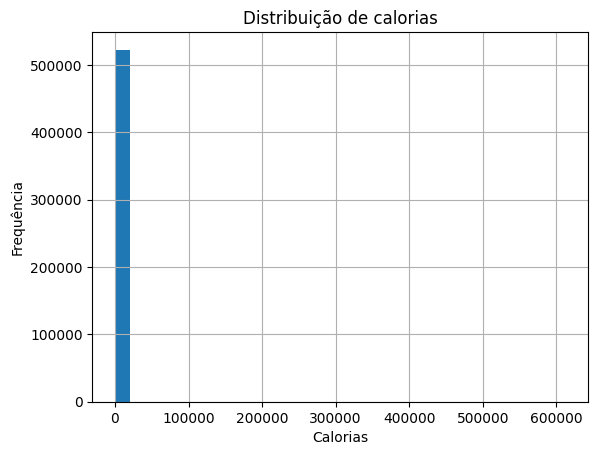

In [4]:
import matplotlib.pyplot as plt

df["Calories"].dropna().astype(float).hist(bins=30)
plt.title("Distribuição de calorias")
plt.xlabel("Calorias")
plt.ylabel("Frequência")
plt.show()


RECOMENDADOR DE RECEITAS BASEADO EM INGREDIENTES

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import json

df = pd.read_csv("archive/recipes_clean.csv")
df["RecipeIngredientParts_str"] = df["RecipeIngredientParts"].apply(lambda x: " ".join(json.loads(x)))

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df["RecipeIngredientParts_str"])

def recomendar_receitas(ingredientes, top_n=5):
    entrada = " ".join(ingredientes.split(","))
    entrada_tfidf = tfidf.transform([entrada])
    sim = cosine_similarity(entrada_tfidf, X)[0]
    top = sim.argsort()[-top_n:][::-1]
    return df.iloc[top][["Name", "RecipeIngredientParts"]]

recomendar_receitas("tomato, garlic, onion")
